In [1]:
from torch.utils.data import DataLoader, random_split,TensorDataset
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import NN_classes
from torchvision import datasets, transforms
import training_methods
import DataLoading
import pivottablejs
import math
%matplotlib inline
import seaborn as sns

In [2]:
#executions = ["Network_Line_Out_N_101_N_102_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_101_N_105_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_102_N_106_cac1","Network_Line_Out_N_103_N_109_cac1"]
#executions = ["Network_Line_Out_N_101_N_102_cac1"]
#executions = ["Network_Full_Generation_Full","Network_Line_In_N_101_N_102_cac1","Network_Line_In_N_101_N_103_cac1","Network_Line_In_N_101_N_105_cac1"]

executions = ["Network_Existing_Generation_Full"]

sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
executions = all_executions[1:10]
te_s = 0.1
val_s = 0.2

In [3]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227


In [4]:
ts_in,ts_out =  DataLoading.split_tr_val_te(dfs_in,dfs_out,executions,te_s,val_s)

In [5]:
d_ft_in, d_ft_out = DataLoading.concat_and_normalize(ts_in,ts_out,executions)

In [6]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

training_loader = DataLoader(train,batch_size=32)
validation_loader = DataLoader(train,batch_size=32)

In [7]:
def create_model(nb_hidden, input_size, dropout_ratio):
    hidden_sizes = []
    if nb_hidden == 0:
        hidden_sizes.append(input_size)
    elif nb_hidden == 1:
        hidden_sizes.extend([int(math.sqrt(input_size))])
    elif nb_hidden == 2:
        hidden_sizes.extend([int(math.sqrt(input_size)), int(math.sqrt(math.sqrt(input_size)))])
    elif nb_hidden == 3:
        hidden_sizes.extend([int(input_size / 4), int(input_size / 16), int(input_size / 64)])



    if nb_hidden == 0:
        model_class = NN_classes.ObjectiveEstimator_ANN_Single_layer
    elif nb_hidden == 1:
        model_class = NN_classes.ObjectiveEstimator_ANN_1hidden_layer
    elif nb_hidden == 2:
        model_class = NN_classes.ObjectiveEstimator_ANN_2hidden_layer
    elif nb_hidden == 3:
        model_class = NN_classes.ObjectiveEstimator_ANN_3hidden_layer
    model = model_class(input_size=input_size, hidden_sizes=hidden_sizes, output_size=1, dropout_ratio=dor)
    print(model,dor,nb_hidden)
    return model

In [13]:
learning_rates = [0.01*4**i for i in range(3)]
loss_fn = torch.nn.MSELoss()
nbs_e = [4,8,12]#,4,8]
i=0
nbs_hidden = [0,1,2,3]
dors = [0,0.1,0.2,0.4]
results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w"
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            for dor in dors:
                m = create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
                m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
                optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)

                saved_models = dict()

                for mt in ["min_val","all_epochs"]:
                    path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"


                    model = m
                    m.load_state_dict(torch.load(path))
                    m.eval()

                    test_predictions = m(d_ft_in["test"].float())
                    test_loss = loss_fn(test_predictions,d_ft_out["test"])

                    train_predictions = m(d_ft_in["train"].float())
                    train_loss = loss_fn(train_predictions,d_ft_out["train"])

                    validation_prediction = m(d_ft_in["val"].float())
                    validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                    if mt == "min_val": 
                        min_val = True
                    else: 
                        min_val = False

                    r = pd.DataFrame({"Model_type": nb_hidden,
                                      "Min_val":min_val,
                                      "Epochs": nb_e,
                                      "Lr":lr,
                                      "Dor": dor,
                                      "Tr_l":train_loss.item(),
                                      "Te_l":test_loss.item(),
                                      "V_l": validation_loss.item()}
                                     ,index = [i]
                    )
                    i+=1
                    results = pd.concat([results,r])

ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
) 0 0
EPOCH 1:
  batch 1 loss: 0.002182842195034027
  batch 101 loss: 0.0944562729226891
  batch 201 loss: 0.0002686175112830824
  batch 301 loss: 0.00014778208041207107
  batch 401 loss: 0.0005557895180027117


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.02209590472265729 valid 0.0030495452228933573
EPOCH 2:
  batch 1 loss: 0.00010719413869082928
  batch 101 loss: 0.0011753741141706086
  batch 201 loss: 7.706170817982639e-05
  batch 301 loss: 0.00016723255129818426
  batch 401 loss: 0.0009362949762362405
LOSS train 0.0017995639664134678 valid 0.125700443983078
EPOCH 3:
  batch 1 loss: 0.001716688424348831
  batch 101 loss: 0.021757008366912488
  batch 201 loss: 0.0008550262528660824
  batch 301 loss: 0.00036528385641531713
  batch 401 loss: 0.0007340386781947928
LOSS train 0.005778163674911834 valid 0.0006494916160590947
EPOCH 4:
  batch 1 loss: 2.1327551803551615e-06
  batch 101 loss: 0.00020292409256626344
  batch 201 loss: 0.00013817979303212268
  batch 301 loss: 5.108832147925568e-05
  batch 401 loss: 0.0002910484134372382
LOSS train 0.00016061930331099787 valid 0.000310040166368708


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1971])) that is different to the input size (torch.Size([1971, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([14148])) that is different to the input size (torch.Size([14148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3537])) that is different to the input size (torch.Size([3537, 1])). This will likely lead to incorrect results due to broadcastin

ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 0.1 0
EPOCH 1:
  batch 1 loss: 0.0019286046922206879
  batch 101 loss: 0.10165136162191629
  batch 201 loss: 0.002761654840433039
  batch 301 loss: 0.0011659573629731312
  batch 401 loss: 0.000354746902739862
LOSS train 0.024364445742974417 valid 0.00032597052631899714
EPOCH 2:
  batch 1 loss: 8.273680577985943e-07
  batch 101 loss: 8.759126347285929e-05
  batch 201 loss: 3.798780745910335e-05
  batch 301 loss: 6.65052009799183e-05
  batch 401 loss: 0.00020504814263404115
LOSS train 0.00011804980138746673 valid 7.29520179447718e-05
EPOCH 3:
  batch 1 loss: 1.0064509842777625e-06
  batch 101 loss: 0.00012569389261443575
  batch 201 loss: 7.460362454366986e-05
  batch 301 loss: 6.127745436970144e-05
  batch 401 loss: 5.0284304988963414e-05
LOSS train 9.134343034730626e-05 valid 0.0007858521421439946
EPOCH 4:
  batch 1 loss: 7.750483346171

  batch 301 loss: 0.00010576161986080024
  batch 401 loss: 9.943925805828258e-05
LOSS train 0.00010286914432304202 valid 0.00022368664212990552
EPOCH 3:
  batch 1 loss: 3.189128474332392e-06
  batch 101 loss: 9.171075853430466e-05
  batch 201 loss: 8.57118379599342e-05
  batch 301 loss: 7.742300143434022e-05
  batch 401 loss: 7.153913338811435e-05
LOSS train 7.955470673951078e-05 valid 0.00018139780149795115
EPOCH 4:
  batch 1 loss: 2.5848124641925095e-06
  batch 101 loss: 6.827742295286044e-05
  batch 201 loss: 0.012258925817292265
  batch 301 loss: 0.00041256655990423496
  batch 401 loss: 8.420100535602159e-05
LOSS train 0.002901175626292448 valid 0.00020535623480100185
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0 2
EPOCH 1:
  batch 1 loss: 0

LOSS train 0.009175207235010916 valid 7.783670298522338e-05
EPOCH 2:
  batch 1 loss: 2.6198552222922442e-06
  batch 101 loss: 0.00014253932793508283
  batch 201 loss: 9.276791335651069e-05
  batch 301 loss: 8.486363916745177e-05
  batch 401 loss: 8.112609168165364e-05
LOSS train 9.812878871132393e-05 valid 0.00017225848569069058
EPOCH 3:
  batch 1 loss: 3.0652398709207772e-06
  batch 101 loss: 8.679354496962332e-05
  batch 201 loss: 8.161289058080001e-05
  batch 301 loss: 7.401689040307247e-05
  batch 401 loss: 6.921253398104455e-05
LOSS train 7.645998402641816e-05 valid 0.0001660757843637839
EPOCH 4:
  batch 1 loss: 2.343585656490177e-06
  batch 101 loss: 6.656155017935817e-05
  batch 201 loss: 6.341146097838646e-05
  batch 301 loss: 5.991584435150799e-05
  batch 401 loss: 5.9436834852704124e-05
LOSS train 6.169499894415741e-05 valid 0.0001519691286375746
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): L

  batch 201 loss: 9.175960834909347e-05
  batch 301 loss: 0.00012311155960560428
  batch 401 loss: 0.0005043538645077205
LOSS train 0.0004283110032841704 valid 0.008846352808177471
EPOCH 4:
  batch 1 loss: 8.7820403277874e-05
  batch 101 loss: 0.0026866770829656163
  batch 201 loss: 0.0017617930579581298
  batch 301 loss: 0.0019980057267821394
  batch 401 loss: 0.009894407619722188
LOSS train 0.016658539461556918 valid 1.1270445585250854
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0 1
EPOCH 1:
  batch 1 loss: 0.00015809055417776108
  batch 101 loss: 0.7768675114708095
  batch 201 loss: 8.689303097526136e-05
  batch 301 loss: 8.48380915067537e-05
  batch 401 loss: 9.211899974388871e-05
LOSS train 0.17546869476414587 valid 9.930014493875206e-05
EPOCH 2:
  batch 1 loss: 1.2758185039274395e-06
  batch 101 loss: 9.97

  batch 201 loss: 2.3900585572391718e-05
  batch 301 loss: 2.2493402967711516e-05
  batch 401 loss: 2.4202371634487462e-05
LOSS train 2.5109387577108065e-05 valid 9.309567394666374e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.2 2
EPOCH 1:
  batch 1 loss: 0.00026735689491033557
  batch 101 loss: 0.9581720612373101
  batch 201 loss: 9.095572431760957e-05
  batch 301 loss: 8.611850057377524e-05
  batch 401 loss: 9.366346937667913e-05
LOSS train 0.21642148635401914 valid 0.00010448905959492549
EPOCH 2:
  batch 1 loss: 1.3692285574506968e-06
  batch 101 loss: 0.00010138277127452966
  batch 201 loss: 0.00010612431748768358
  batch 301 loss: 0.00010857010805011669
  batch 401 loss: 0.00010942873851078616
LOSS train 0.00010419340369808623 valid 0

  batch 201 loss: 8.752197229114245e-05
  batch 301 loss: 8.980792192460285e-05
  batch 401 loss: 9.29437370064079e-05
LOSS train 8.885552110163267e-05 valid 9.205032256431878e-05
EPOCH 4:
  batch 1 loss: 1.1401851224945859e-06
  batch 101 loss: 9.656798488322238e-05
  batch 201 loss: 9.915428307976981e-05
  batch 301 loss: 0.00010123816450686718
  batch 401 loss: 0.00010409364027282209
LOSS train 9.926433318658087e-05 valid 0.00013328972272574902
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
) 0 0
EPOCH 1:
  batch 1 loss: 1.1546082096174359e-05
  batch 101 loss: 46.06924241340719
  batch 201 loss: 0.024281597959343343
  batch 301 loss: 0.005991633452649694
  batch 401 loss: 0.002479370905057294
LOSS train 10.406919818470975 valid 0.00046740405377931893
EPOCH 2:
  batch 1 loss: 2.939442056231201e-06
  batch 101 loss: 0.0004988865173982049
  batch 201 loss: 0.00027666286740895884
  batc

  batch 201 loss: 1.4517976689967327
  batch 301 loss: 0.00026231617719531643
  batch 401 loss: 7.215859767711663e-05
LOSS train 16.97962883958658 valid 6.453751120716333e-05
EPOCH 2:
  batch 1 loss: 4.795142012881115e-07
  batch 101 loss: 7.501411430894223e-05
  batch 201 loss: 7.697252922298504e-05
  batch 301 loss: 7.889759316640266e-05
  batch 401 loss: 8.167349906671007e-05
LOSS train 7.849949935350174e-05 valid 7.239239494083449e-05
EPOCH 3:
  batch 1 loss: 7.170331809902563e-07
  batch 101 loss: 8.499498767832847e-05
  batch 201 loss: 8.714254438928037e-05
  batch 301 loss: 8.936374282711768e-05
  batch 401 loss: 9.25052067100296e-05
LOSS train 8.839043857579509e-05 valid 9.11992829060182e-05
EPOCH 4:
  batch 1 loss: 1.1237899161642418e-06
  batch 101 loss: 9.61957425511173e-05
  batch 201 loss: 9.858195839569817e-05
  batch 301 loss: 0.00010077077463392925
  batch 401 loss: 0.00010362517162775476
LOSS train 9.884160384885216e-05 valid 0.00013077397306915373
ObjectiveEstimator_A

  batch 301 loss: 0.32465819776058197
  batch 401 loss: 0.16524896405637265
LOSS train 1850.64847413584 valid 0.07671909034252167
EPOCH 2:
  batch 1 loss: 0.0007387204468250275
  batch 101 loss: 0.05003260234370828
  batch 201 loss: 0.018669546227902175
  batch 301 loss: 0.00616919350810349
  batch 401 loss: 0.0018296432128408924
LOSS train 0.017552138107598068 valid 0.0005256248987279832
EPOCH 3:
  batch 1 loss: 2.7262367075309157e-06
  batch 101 loss: 0.000289157085462648
  batch 201 loss: 0.00010761944508971056
  batch 301 loss: 6.944409378093042e-05
  batch 401 loss: 6.388080947999697e-05
LOSS train 0.0001268955068572999 valid 6.15820026723668e-05
EPOCH 4:
  batch 1 loss: 2.5707797249197026e-07
  batch 101 loss: 6.311579968496517e-05
  batch 201 loss: 6.362966310916817e-05
  batch 301 loss: 6.363134256389458e-05
  batch 401 loss: 6.417689245608926e-05
LOSS train 6.411467974169971e-05 valid 6.170683627715334e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_feat

  batch 201 loss: 3.3004738024828836e-05
  batch 301 loss: 4.144651832120872e-05
  batch 401 loss: 5.7149485769514285e-05
LOSS train 4.926161934726682e-05 valid 8.407712448388338e-05
EPOCH 4:
  batch 1 loss: 5.45614275324624e-07
  batch 101 loss: 6.226617101447118e-05
  batch 201 loss: 9.057587026291003e-05
  batch 301 loss: 0.0012144784780957706
  batch 401 loss: 0.013815496138849994
LOSS train 0.003641010690193107 valid 0.001660963986068964
EPOCH 5:
  batch 1 loss: 1.626716461032629e-05
  batch 101 loss: 0.0008607258494521374
  batch 201 loss: 0.00014538357503624867
  batch 301 loss: 0.0006343538269356941
  batch 401 loss: 0.010342623715041554
LOSS train 0.0029108567681879255 valid 0.0012657990446314216
EPOCH 6:
  batch 1 loss: 1.6563106328248978e-05
  batch 101 loss: 0.0009892262245557505
  batch 201 loss: 0.0017959444217194686
  batch 301 loss: 0.0043945116276154295
  batch 401 loss: 0.004111566151550505
LOSS train 0.0031692065133016928 valid 0.014708802103996277
EPOCH 7:
  batch 1

  batch 101 loss: 6.009632991094804e-05
  batch 201 loss: 5.950395527520414e-05
  batch 301 loss: 5.813030849765255e-05
  batch 401 loss: 5.863061910702072e-05
LOSS train 5.8982051645083994e-05 valid 0.00015408704348374158
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.1 1
EPOCH 1:
  batch 1 loss: 0.0004572950303554535
  batch 101 loss: 0.044725717011215235
  batch 201 loss: 7.870507996813103e-05
  batch 301 loss: 8.614750054221076e-05
  batch 401 loss: 9.371469595635062e-05
LOSS train 0.010266052864224181 valid 0.00010453374852659181
EPOCH 2:
  batch 1 loss: 1.3700214913114906e-06
  batch 101 loss: 0.00010138662668737197
  batch 201 loss: 0.00010608131111098374
  batch 301 loss: 0.0001085171104807614
  batch 401 loss: 0.00010945257702729805
LOSS train 0.00010420246641254372 valid 0.00019982142839580774
EPOCH 3

  batch 101 loss: 7.999218954694242e-05
  batch 201 loss: 7.439264211029694e-05
  batch 301 loss: 6.761916574987481e-05
  batch 401 loss: 6.353982473001452e-05
LOSS train 6.994350212543812e-05 valid 0.00016602034156676382
EPOCH 4:
  batch 1 loss: 2.357234770897776e-06
  batch 101 loss: 6.265474682805917e-05
  batch 201 loss: 6.07056858427768e-05
  batch 301 loss: 5.8034520199043984e-05
  batch 401 loss: 5.744779551577039e-05
LOSS train 5.922098647034149e-05 valid 0.00015683921810705215
EPOCH 5:
  batch 1 loss: 2.2187421564012764e-06
  batch 101 loss: 6.0300243454776137e-05
  batch 201 loss: 5.988602566844747e-05
  batch 301 loss: 5.871175747699908e-05
  batch 401 loss: 5.940007919321033e-05
LOSS train 5.959675343255987e-05 valid 0.00014720491890329868
EPOCH 6:
  batch 1 loss: 2.0709275850094854e-06
  batch 101 loss: 6.123534288235533e-05
  batch 201 loss: 6.008818400573546e-05
  batch 301 loss: 5.8250264391972454e-05
  batch 401 loss: 5.775769823458177e-05
LOSS train 5.930656431955785e

  batch 201 loss: 5.813528674252666e-05
  batch 301 loss: 5.600419193342532e-05
  batch 401 loss: 5.500334412545271e-05
LOSS train 5.710744560143216e-05 valid 9.049671643879265e-05
EPOCH 7:
  batch 1 loss: 1.1097786045866087e-06
  batch 101 loss: 5.087858162028169e-05
  batch 201 loss: 4.949695874415738e-05
  batch 301 loss: 4.80865239021e-05
  batch 401 loss: 4.7552468660683187e-05
LOSS train 4.8902902859778063e-05 valid 7.443709182552993e-05
EPOCH 8:
  batch 1 loss: 7.675332017242909e-07
  batch 101 loss: 4.5026088784112514e-05
  batch 201 loss: 4.487559557418308e-05
  batch 301 loss: 4.5105911835321424e-05
  batch 401 loss: 4.6066393940407126e-05
LOSS train 4.536658554674556e-05 valid 7.191531040007249e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0, inp

  batch 401 loss: 4.6833704930691054e-05
LOSS train 4.554728779285306e-05 valid 7.087708218023181e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.4 3
EPOCH 1:
  batch 1 loss: 0.00022150322794914245
  batch 101 loss: 0.02326404660649132
  batch 201 loss: 0.0001918231907984591
  batch 301 loss: 9.816593321374966e-05
  batch 401 loss: 0.00011168564243234869
LOSS train 0.0053999197412689616 valid 0.00022361586161423475
EPOCH 2:
  batch 1 loss: 2.8247441514395178e-06
  batch 101 loss: 0.00010540811879309331
  batch 201 loss: 9.929645454803904e-05
  batch 301 loss: 8.912193109836153e-05
  batch 401 loss: 8.142575940496499e-05
LOSS train 9.092314464091747e-05 valid 0.00020032

  batch 401 loss: 0.0003728268063059659
LOSS train 0.0017129452975224951 valid 0.00331152998842299
EPOCH 5:
  batch 1 loss: 3.5278687719255685e-05
  batch 101 loss: 0.021121802807901987
  batch 201 loss: 0.18000512858852744
  batch 301 loss: 0.13137427026405932
  batch 401 loss: 0.0213396650494542
LOSS train 0.0808823258019763 valid 0.06325409561395645
EPOCH 6:
  batch 1 loss: 0.0004966526478528976
  batch 101 loss: 0.08790205617900938
  batch 201 loss: 0.030338022885844113
  batch 301 loss: 0.08583440009853803
  batch 401 loss: 0.13475583692081272
LOSS train 0.08090583463730269 valid 0.21316634118556976
EPOCH 7:
  batch 1 loss: 0.0018599201738834382
  batch 101 loss: 0.07618320208974183
  batch 201 loss: 0.020715832896530628
  batch 301 loss: 0.013055048669921234
  batch 401 loss: 0.1296879740303848
LOSS train 0.07913182895897591 valid 0.16813252866268158
EPOCH 8:
  batch 1 loss: 0.0020539993047714233
  batch 101 loss: 0.2644154670089483
  batch 201 loss: 0.0711570662073791
  batch 30

  batch 101 loss: 0.44484817397583354
  batch 201 loss: 9.536155882869935e-05
  batch 301 loss: 9.463896631359603e-05
  batch 401 loss: 0.06091628784268778
LOSS train 0.11425935415668319 valid 0.0001352795516140759
EPOCH 2:
  batch 1 loss: 1.8837675452232361e-06
  batch 101 loss: 0.00010788235510347022
  batch 201 loss: 0.00011019201520952037
  batch 301 loss: 0.00010843888238127874
  batch 401 loss: 0.00010417382712830658
LOSS train 0.00010466053649441044 valid 0.0002243590133730322
EPOCH 3:
  batch 1 loss: 3.1985368696041405e-06
  batch 101 loss: 9.736702209139026e-05
  batch 201 loss: 9.158854594716103e-05
  batch 301 loss: 8.281200652845655e-05
  batch 401 loss: 7.607022193951707e-05
LOSS train 8.46088353592704e-05 valid 0.00018986177747137845
EPOCH 4:
  batch 1 loss: 2.708056999836117e-06
  batch 101 loss: 7.158854062708996e-05
  batch 201 loss: 6.776167749990236e-05
  batch 301 loss: 6.284494447186261e-05
  batch 401 loss: 6.024154680233096e-05
LOSS train 6.456134363276143e-05 va

  batch 401 loss: 0.00010035760824905537
LOSS train 0.00010295076026715492 valid 0.00022398997680284083
EPOCH 5:
  batch 1 loss: 3.193375887349248e-06
  batch 101 loss: 9.546158183809439e-05
  batch 201 loss: 9.144406158299035e-05
  batch 301 loss: 8.434044620969416e-05
  batch 401 loss: 7.87830923366073e-05
LOSS train 8.527123958947054e-05 valid 0.00019666070875246078
EPOCH 6:
  batch 1 loss: 2.8061450575478376e-06
  batch 101 loss: 7.496896779571216e-05
  batch 201 loss: 7.143395752336801e-05
  batch 301 loss: 6.626215964388394e-05
  batch 401 loss: 6.316017319022648e-05
LOSS train 6.770760205808346e-05 valid 0.00016623463307041675
EPOCH 7:
  batch 1 loss: 2.360441576456651e-06
  batch 101 loss: 6.286113449505137e-05
  batch 201 loss: 6.107286444944294e-05
  batch 301 loss: 5.835643695377257e-05
  batch 401 loss: 5.75880809424234e-05
LOSS train 5.941578380347881e-05 valid 0.00015707944112364203
EPOCH 8:
  batch 1 loss: 2.2223949781619013e-06
  batch 101 loss: 6.014395901729586e-05
  

  batch 401 loss: 8.484161181456784e-05
LOSS train 9.03652538016542e-05 valid 0.0002078743709716946
EPOCH 8:
  batch 1 loss: 2.9663110035471618e-06
  batch 101 loss: 8.075011261098553e-05
  batch 201 loss: 7.713153504710135e-05
  batch 301 loss: 7.137979007893592e-05
  batch 401 loss: 6.756409655167772e-05
LOSS train 7.267638217703357e-05 valid 0.00017514883074909449
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.1 3
EPOCH 1:
  batch 1 loss: 8.671771734952927e-05
  batch 101 loss: 29.19448794039432
  batch 201 loss: 0.005715275695547461
  batch 301 loss: 0.004335351929184981
  batch 401 loss: 0.003416164197260514
LOSS train 6.59345871853899 valid 0.0008336320170201361
EPO

  batch 401 loss: 0.002989785164463683
LOSS train 10.286959293668454 valid 0.003889512736350298
EPOCH 2:
  batch 1 loss: 1.5997900627553464e-05
  batch 101 loss: 0.0005897601510332606
  batch 201 loss: 0.00018519499747071677
  batch 301 loss: 0.00015578635170641065
  batch 401 loss: 0.0003830221847601933
LOSS train 0.00038290373762079715 valid 0.005832959897816181
EPOCH 3:
  batch 1 loss: 4.46633854880929e-05
  batch 101 loss: 0.0004873673975077963
  batch 201 loss: 4.632259157688168e-05
  batch 301 loss: 5.3880283265925757e-05
  batch 401 loss: 0.0006025680545076284
LOSS train 0.0008183105218009406 valid 0.016711533069610596
EPOCH 4:
  batch 1 loss: 0.0001434817537665367
  batch 101 loss: 0.005516155607110705
  batch 201 loss: 0.0014043312500871253
  batch 301 loss: 8.953646899044543e-05
  batch 401 loss: 0.0015997858325579274
LOSS train 0.0023476568862037532 valid 0.007196938619017601
EPOCH 5:
  batch 1 loss: 3.8386881351470946e-05
  batch 101 loss: 0.00433823686611504
  batch 201 lo

  batch 401 loss: 0.07379503490403294
LOSS train 0.20940905929551026 valid 4.334351539611816
EPOCH 8:
  batch 1 loss: 0.06772991180419922
  batch 101 loss: 11.240366473197938
  batch 201 loss: 6.420664654970169
  batch 301 loss: 0.22361682588234544
  batch 401 loss: 0.023789995990227908
LOSS train 4.058587961668584 valid 0.002096942625939846
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0 1
EPOCH 1:
  batch 1 loss: 0.0001601489447057247
  batch 101 loss: 122.91590033881366
  batch 201 loss: 0.029890687958686612
  batch 301 loss: 0.00021484700424366564
  batch 401 loss: 6.846295782452217e-05
LOSS train 27.7531073749635 valid 6.311695324257016e-05
EPOCH 2:
  batch 1 loss: 4.1685238102218134e-07
  batch 101 loss: 7.144899271224858e-05
  batch 201 loss: 7.284623963641934e-05
  batch 301 loss: 7.41650305371877e-05
  ba

  batch 101 loss: 8.734336464385705e-05
  batch 201 loss: 8.97075071134168e-05
  batch 301 loss: 9.212569968212847e-05
  batch 401 loss: 9.542774925193954e-05
LOSS train 9.088317102944265e-05 valid 9.924911864800379e-05
EPOCH 4:
  batch 1 loss: 1.274885726161301e-06
  batch 101 loss: 9.9220733503671e-05
  batch 201 loss: 0.00010170520451083576
  batch 301 loss: 0.00010374230911224913
  batch 401 loss: 0.00010626363201595268
LOSS train 0.00010146540649645963 valid 0.00014720206672791392
EPOCH 5:
  batch 1 loss: 2.070884365821257e-06
  batch 101 loss: 0.00010855318629808152
  batch 201 loss: 0.00011006351487026222
  batch 301 loss: 0.00010947965779649849
  batch 401 loss: 0.00010872802438484541
LOSS train 0.00010678029790173371 valid 0.0002059393300442025
EPOCH 6:
  batch 1 loss: 2.9388052644208074e-06
  batch 101 loss: 0.00010705558137431127
  batch 201 loss: 0.00010555191595017277
  batch 301 loss: 0.00010049850192444864
  batch 401 loss: 9.574927978405867e-05
LOSS train 9.946056723161

  batch 201 loss: 3.566321330168876e-05
  batch 301 loss: 3.613944493281451e-05
  batch 401 loss: 3.648417652854619e-05
LOSS train 3.6516443478320514e-05 valid 6.24066378804855e-05
EPOCH 7:
  batch 1 loss: 3.7656514905393124e-07
  batch 101 loss: 3.820214422148638e-05
  batch 201 loss: 3.883090947454093e-05
  batch 301 loss: 4.1872285663089315e-05
  batch 401 loss: 4.4896124068714014e-05
LOSS train 4.171501121356843e-05 valid 9.386680176248774e-05
EPOCH 8:
  batch 1 loss: 1.1748165707103908e-06
  batch 101 loss: 5.3300139556569095e-05
  batch 201 loss: 5.6629206519147604e-05
  batch 301 loss: 6.379399200298508e-05
  batch 401 loss: 6.274189246084916e-05
LOSS train 5.9137742772778125e-05 valid 8.836795313982293e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1

  batch 101 loss: 37188.069709569514
  batch 201 loss: 0.6198874482512474
  batch 301 loss: 0.4860705474019051
  batch 401 loss: 0.36802402153611186
LOSS train 8394.957794015205 valid 0.2585938572883606
EPOCH 2:
  batch 1 loss: 0.0027778786420822143
  batch 101 loss: 0.2177383990585804
  batch 201 loss: 0.14051441498100758
  batch 301 loss: 0.08781557157635689
  batch 401 loss: 0.05113318188115954
LOSS train 0.11631600902274958 valid 0.028462989255785942
EPOCH 3:
  batch 1 loss: 0.0002449151873588562
  batch 101 loss: 0.022525840867310763
  batch 201 loss: 0.012192716021090746
  batch 301 loss: 0.007142648780718446
  batch 401 loss: 0.003831517754588276
LOSS train 0.010603119710246921 valid 0.0009944505291059613
EPOCH 4:
  batch 1 loss: 2.962392522022128e-05
  batch 101 loss: 0.001587142798525747
  batch 201 loss: 0.0008926457300185575
  batch 301 loss: 0.00068948512107454
  batch 401 loss: 0.00046145867856466793
LOSS train 0.0008688097693079346 valid 6.170170672703534e-05
EPOCH 5:
  b

LOSS train 0.03656851605687088 valid 5.784961103927344e-05
EPOCH 2:
  batch 1 loss: 2.6861688820645212e-06
  batch 101 loss: 0.00020328136437456124
  batch 201 loss: 8.92232887508726e-05
  batch 301 loss: 3.0103864892225827e-05
  batch 401 loss: 1.864751730863645e-05
LOSS train 7.943384525377525e-05 valid 5.10499048687052e-05
EPOCH 3:
  batch 1 loss: 6.303860573098064e-07
  batch 101 loss: 3.407419805853351e-05
  batch 201 loss: 2.2990435472820535e-05
  batch 301 loss: 3.779279754553499e-05
  batch 401 loss: 4.99270293198606e-05
LOSS train 5.2866581734666506e-05 valid 8.850127051118761e-05
EPOCH 4:
  batch 1 loss: 4.2101059079868717e-07
  batch 101 loss: 0.0001559724599974288
  batch 201 loss: 5.26177734036537e-05
  batch 301 loss: 2.900897738072672e-05
  batch 401 loss: 0.0016845808220296021
LOSS train 0.0008496406112684017 valid 0.0014301579212769866
EPOCH 5:
  batch 1 loss: 4.491159052122384e-06
  batch 101 loss: 0.001502961936639622
  batch 201 loss: 0.00795775474383845
  batch 301

  batch 401 loss: 0.0029684180094045587
LOSS train 0.004754404445469451 valid 0.028977246955037117
EPOCH 8:
  batch 1 loss: 0.0003019717521965504
  batch 101 loss: 0.013295830651768483
  batch 201 loss: 0.0027925331227015705
  batch 301 loss: 0.0015590441497624853
  batch 401 loss: 0.0009595723188249394
LOSS train 0.004522038876230389 valid 0.002484695753082633
EPOCH 9:
  batch 1 loss: 2.0231581293046474e-05
  batch 101 loss: 0.03860887715476565
  batch 201 loss: 0.05754811262246221
  batch 301 loss: 0.010951792609412224
  batch 401 loss: 0.008938078940846026
LOSS train 0.026653678707174566 valid 0.024624213576316833
EPOCH 10:
  batch 1 loss: 0.00033106390386819837
  batch 101 loss: 0.0040650507138343525
  batch 201 loss: 0.0009903496190963779
  batch 301 loss: 0.000622715375648113
  batch 401 loss: 0.0006364447161467979
LOSS train 0.001700631641955538 valid 0.0027649765834212303
EPOCH 11:
  batch 1 loss: 4.028400406241417e-05
  batch 101 loss: 0.0010316311329370365
  batch 201 loss: 0

  batch 301 loss: 4.87714108334103e-05
  batch 401 loss: 4.819637177703839e-05
LOSS train 4.8002162012431024e-05 valid 6.166492676129565e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.2 1
EPOCH 1:
  batch 1 loss: 6.906733382493258e-05
  batch 101 loss: 0.042769454528606726
  batch 201 loss: 7.64891933886247e-05
  batch 301 loss: 8.0464538606293e-05
  batch 401 loss: 9.530207193392926e-05
LOSS train 0.00973542785467442 valid 0.00011062600970035419
EPOCH 2:
  batch 1 loss: 1.4765864762011915e-06
  batch 101 loss: 0.00010299892063244443
  batch 201 loss: 0.00010748065127984319
  batch 301 loss: 0.00010918240565160886
  batch 401 loss: 0.00010906123619534469
LOSS train 0.00010479592864501393 valid 0.00020840934303123504
EPOCH 3:
  batch 1 loss: 2.9739030287601053e-06
  batch 101 loss: 0.00010617384494537418
  b

  batch 101 loss: 5.892156762570267e-05
  batch 201 loss: 5.6806939320495075e-05
  batch 301 loss: 5.433322584622147e-05
  batch 401 loss: 5.292269575306818e-05
LOSS train 5.5557740069896794e-05 valid 8.330933633260429e-05
EPOCH 5:
  batch 1 loss: 9.655983740231021e-07
  batch 101 loss: 4.8526039728358227e-05
  batch 201 loss: 4.733396754545538e-05
  batch 301 loss: 4.633987812155738e-05
  batch 401 loss: 4.6269580096236496e-05
LOSS train 4.707365880684874e-05 valid 7.293290400411934e-05
EPOCH 6:
  batch 1 loss: 7.306775660254061e-07
  batch 101 loss: 4.4494670980839146e-05
  batch 201 loss: 4.480988322370649e-05
  batch 301 loss: 4.5638935929446234e-05
  batch 401 loss: 4.7071973010588405e-05
LOSS train 4.566266496612717e-05 valid 7.046003156574443e-05
EPOCH 7:
  batch 1 loss: 6.66433697915636e-07
  batch 101 loss: 4.6109068026680685e-05
  batch 201 loss: 4.739278201043362e-05
  batch 301 loss: 4.8725165019050106e-05
  batch 401 loss: 4.95596111602481e-05
LOSS train 4.8064785336460304

  batch 201 loss: 3.640088331906099e-05
  batch 301 loss: 3.7010839112667784e-05
  batch 401 loss: 3.6990238115919286e-05
LOSS train 3.732876386317525e-05 valid 6.22130319243297e-05
EPOCH 9:
  batch 1 loss: 3.6330096918391065e-07
  batch 101 loss: 3.746506822920992e-05
  batch 201 loss: 3.6686409985122736e-05
  batch 301 loss: 3.728593522453138e-05
  batch 401 loss: 3.723043202484178e-05
LOSS train 3.761971385581346e-05 valid 6.257308996282518e-05
EPOCH 10:
  batch 1 loss: 3.8697195122949777e-07
  batch 101 loss: 3.7691054142499066e-05
  batch 201 loss: 3.684566544222889e-05
  batch 301 loss: 3.7434720779288e-05
  batch 401 loss: 3.735648270755121e-05
LOSS train 3.777933984001343e-05 valid 6.277571810642257e-05
EPOCH 11:
  batch 1 loss: 3.98725678678602e-07
  batch 101 loss: 3.780617791989016e-05
  batch 201 loss: 3.692610650659844e-05
  batch 301 loss: 3.750875371849816e-05
  batch 401 loss: 3.7418308720873484e-05
LOSS train 3.785941896405859e-05 valid 6.287777796387672e-05
EPOCH 12:


  batch 201 loss: 3.59349339231585e-05
  batch 301 loss: 3.6152296978002596e-05
  batch 401 loss: 3.586539799186994e-05
LOSS train 3.6401710309192127e-05 valid 6.290867167990655e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.1 3
EPOCH 1:
  batch 1 loss: 1.922872324939817e-06
  batch 101 loss: 0.020720105804866763
  batch 201 loss: 0.00010835652188688983
  batch 301 loss: 6.14401610346249e-05
  batch 401 loss: 4.147242173758059e-05
LOSS train 0.004729426103761811 valid 6.695219053654e-05
EPOCH 2:
  batch 1 loss: 7.674569496884942e-07
  batch 101 loss: 6.175972455281453e-05
  batch 201 loss: 0.00010043111304639751
  batch 301 loss: 9.670215422431738e-05
  batch 401 loss

  batch 401 loss: 0.00011062502469712854
LOSS train 0.0001101336354542549 valid 0.00019136720220558345
EPOCH 3:
  batch 1 loss: 2.7586071519181134e-06
  batch 101 loss: 0.00010999076604548464
  batch 201 loss: 0.00010891983571127639
  batch 301 loss: 0.00010281753465505972
  batch 401 loss: 9.921067835193754e-05
LOSS train 0.00010228548000687003 valid 0.00023247904027812183
EPOCH 4:
  batch 1 loss: 3.1963948276825247e-06
  batch 101 loss: 9.335280175093886e-05
  batch 201 loss: 8.857112697000957e-05
  batch 301 loss: 8.157811844284879e-05
  batch 401 loss: 7.58086674727565e-05
LOSS train 8.272878951383172e-05 valid 0.0001956207415787503
EPOCH 5:
  batch 1 loss: 2.70044372882694e-06
  batch 101 loss: 7.280175555479218e-05
  batch 201 loss: 6.955551137707516e-05
  batch 301 loss: 6.488551174925305e-05
  batch 401 loss: 6.180415582662135e-05
LOSS train 6.612440447487382e-05 valid 0.0001625522127142176
EPOCH 6:
  batch 1 loss: 2.2797644487582147e-06
  batch 101 loss: 6.210737565709223e-05


  batch 401 loss: 0.0008006428012595279
LOSS train 0.11669667115687675 valid 0.00034504756331443787
EPOCH 9:
  batch 1 loss: 4.9900403246283534e-06
  batch 101 loss: 0.0010309500389848836
  batch 201 loss: 0.00023774133927872753
  batch 301 loss: 0.01079593118007324
  batch 401 loss: 0.1921135709132068
LOSS train 0.049252627795684116 valid 0.07408716529607773
EPOCH 10:
  batch 1 loss: 0.000710124745965004
  batch 101 loss: 0.04050446670968086
  batch 201 loss: 0.019105831198394298
  batch 301 loss: 0.03587799486529548
  batch 401 loss: 0.11147653413936495
LOSS train 0.05038737352797131 valid 0.013959981501102448
EPOCH 11:
  batch 1 loss: 0.00021850652992725373
  batch 101 loss: 0.0828969986201264
  batch 201 loss: 0.03327949234982953
  batch 301 loss: 0.04226298462599516
  batch 401 loss: 0.11287274647969753
LOSS train 0.06801299031184772 valid 0.20399019122123718
EPOCH 12:
  batch 1 loss: 0.00189706951379776
  batch 101 loss: 0.06446689781732858
  batch 201 loss: 0.015010663317516446


  batch 101 loss: 8.165104761701514e-05
  batch 201 loss: 9.375077190725279e-05
  batch 301 loss: 9.781553195580273e-05
  batch 401 loss: 0.00010217079245194326
LOSS train 9.320847094056896e-05 valid 0.00012871624494437128
EPOCH 3:
  batch 1 loss: 1.7783990188036113e-06
  batch 101 loss: 0.00010631802297098148
  batch 201 loss: 0.00010890973330049292
  batch 301 loss: 0.00010937325414772658
  batch 401 loss: 0.00010914135870706332
LOSS train 0.00010607708834797304 valid 0.00020386312098708004
EPOCH 4:
  batch 1 loss: 2.909236936829984e-06
  batch 101 loss: 0.00010731324379833041
  batch 201 loss: 0.0001053785996350598
  batch 301 loss: 9.960081833014556e-05
  batch 401 loss: 9.402458099174283e-05
LOSS train 9.874639785859039e-05 valid 0.00021988400840200484
EPOCH 5:
  batch 1 loss: 3.135845763608813e-06
  batch 101 loss: 8.865691377025087e-05
  batch 201 loss: 8.430771526434456e-05
  batch 301 loss: 7.74154731800536e-05
  batch 401 loss: 7.244776057973467e-05
LOSS train 7.8804164158845

  batch 101 loss: 6.147415931764045e-05
  batch 201 loss: 6.0521804420829995e-05
  batch 301 loss: 5.8764939224147385e-05
  batch 401 loss: 5.837416714371102e-05
LOSS train 5.977658259159796e-05 valid 0.00010738939454313368
EPOCH 8:
  batch 1 loss: 1.4203498722054064e-06
  batch 101 loss: 5.490302546604653e-05
  batch 201 loss: 5.279996034801116e-05
  batch 301 loss: 5.05711453308777e-05
  batch 401 loss: 4.934439216583542e-05
LOSS train 5.171187650569953e-05 valid 7.631319749634713e-05
EPOCH 9:
  batch 1 loss: 8.120774873532355e-07
  batch 101 loss: 4.581009166820138e-05
  batch 201 loss: 4.524291711874184e-05
  batch 301 loss: 4.513713737367198e-05
  batch 401 loss: 4.598357033898992e-05
LOSS train 4.5621524588994595e-05 valid 7.178078521974385e-05
EPOCH 10:
  batch 1 loss: 7.013439608272165e-07
  batch 101 loss: 4.5184376231190984e-05
  batch 201 loss: 4.6408234426280613e-05
  batch 301 loss: 4.8149309727136824e-05
  batch 401 loss: 4.9487201043803e-05
LOSS train 4.7503561067913256e

  batch 401 loss: 6.061480666176067e-05
LOSS train 5.760761777465112e-05 valid 6.783900607842952e-05
EPOCH 12:
  batch 1 loss: 8.228176739066839e-08
  batch 101 loss: 5.258763480242124e-05
  batch 201 loss: 5.618316052732552e-05
  batch 301 loss: 5.37592381206764e-05
  batch 401 loss: 5.194403473609555e-05
LOSS train 5.353173495671093e-05 valid 7.032733265077695e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.1 2
EPOCH 1:
  batch 1 loss: 5.2067753858864305e-05
  batch 101 loss: 0.15896563101487915
  batch 201 loss: 0.00010935055334925891
  batch 301 loss: 0.00010885848143971089
  batch 401 loss: 0.00010155803099792137
LOSS train 0.035974357389351896 valid 0.00022300965792965144
EPOCH 2:
  batch 1 loss: 3.1796589610166848e-06
  batch 101 loss

LOSS train 5.936141215290492e-05 valid 0.00015254062600433826
EPOCH 3:
  batch 1 loss: 2.1531301899813117e-06
  batch 101 loss: 6.135465433018794e-05
  batch 201 loss: 6.0087243613224926e-05
  batch 301 loss: 5.7744372558659055e-05
  batch 401 loss: 5.6334771429646934e-05
LOSS train 5.872794747853601e-05 valid 9.161820344161242e-05
EPOCH 4:
  batch 1 loss: 1.1318739416310564e-06
  batch 101 loss: 5.075397383734526e-05
  batch 201 loss: 4.8524930960525126e-05
  batch 301 loss: 4.677828318790489e-05
  batch 401 loss: 4.6311557139802064e-05
LOSS train 4.798412204656978e-05 valid 7.260379788931459e-05
EPOCH 5:
  batch 1 loss: 7.223947613965719e-07
  batch 101 loss: 4.4474546775745694e-05
  batch 201 loss: 4.509445555413549e-05
  batch 301 loss: 4.655274324534275e-05
  batch 401 loss: 4.851761177064873e-05
LOSS train 4.6404527191933586e-05 valid 6.60617952235043e-05
EPOCH 6:
  batch 1 loss: 5.349710409063846e-07
  batch 101 loss: 4.6755233248063634e-05
  batch 201 loss: 4.799124826774914e-0

  batch 401 loss: 0.00010162122659494343
LOSS train 9.957040350229945e-05 valid 0.00011964223813265562
EPOCH 7:
  batch 1 loss: 1.6293732915073632e-06
  batch 101 loss: 0.00010450898019030319
  batch 201 loss: 0.00010642933389021892
  batch 301 loss: 0.00010742347233758665
  batch 401 loss: 0.00010879208108349303
LOSS train 0.00010503557631802065 valid 0.0001696713879937306
EPOCH 8:
  batch 1 loss: 2.411735331406817e-06
  batch 101 loss: 0.00010976881997294185
  batch 201 loss: 0.00011041715851490607
  batch 301 loss: 0.0001085271026121859
  batch 401 loss: 0.00010650854617438198
LOSS train 0.0001061831670652946 valid 0.00021658148034475744
EPOCH 9:
  batch 1 loss: 3.0894172959961e-06
  batch 101 loss: 0.00010392964163827401
  batch 201 loss: 0.00010180558772447056
  batch 301 loss: 9.618562050661694e-05
  batch 401 loss: 9.125692310306021e-05
LOSS train 9.56872980955894e-05 valid 0.00021734887559432536
EPOCH 10:
  batch 1 loss: 3.10022005578503e-06
  batch 101 loss: 8.700278650167092e

  batch 301 loss: 0.00010180901802470998
  batch 401 loss: 9.768448914485362e-05
LOSS train 0.00010064057863970698 valid 0.00022368962527252734
EPOCH 11:
  batch 1 loss: 3.1891744583845138e-06
  batch 101 loss: 9.355884059544906e-05
  batch 201 loss: 9.018516505648221e-05
  batch 301 loss: 8.389467815106855e-05
  batch 401 loss: 7.889518519505146e-05
LOSS train 8.450136213395143e-05 valid 0.00019851501565426588
EPOCH 12:
  batch 1 loss: 2.832760801538825e-06
  batch 101 loss: 7.564092701784376e-05
  batch 201 loss: 7.254466723793484e-05
  batch 301 loss: 6.744234630559731e-05
  batch 401 loss: 6.42575341612428e-05
LOSS train 6.867356666446131e-05 valid 0.00016881281044334173
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
) 0 0
EPOCH 1:
  batch 1 loss: 5.6536546908318995e-05
  batch 101 loss: 45.926123844292015
  batch 201 loss: 0.02225427721394226
  batch 301 loss: 0.005496393899084069


  batch 401 loss: 0.0001742161551010213
LOSS train 0.0003361622490297482 valid 0.0013080695644021034
EPOCH 5:
  batch 1 loss: 1.4281949261203408e-05
  batch 101 loss: 0.0037584718503057956
  batch 201 loss: 3.297069108702126
  batch 301 loss: 2.5840201649814842
  batch 401 loss: 0.8256775644794107
LOSS train 1.5372583545008873 valid 0.10459519177675247
EPOCH 6:
  batch 1 loss: 0.0017755924165248872
  batch 101 loss: 0.14869044320657848
  batch 201 loss: 0.01803798294160515
  batch 301 loss: 0.9579494312754833
  batch 401 loss: 3.529269043803215
LOSS train 1.1549573179684436 valid 0.8973372578620911
EPOCH 7:
  batch 1 loss: 0.013304710388183594
  batch 101 loss: 0.6134716459736228
  batch 201 loss: 0.11570018326863646
  batch 301 loss: 0.06556728215422482
  batch 401 loss: 1.910380638469942
LOSS train 1.110203163475471 valid 4.065875053405762
EPOCH 8:
  batch 1 loss: 0.03870770215988159
  batch 101 loss: 5.409745552837848
  batch 201 loss: 1.3604300659149886
  batch 301 loss: 0.08288465

LOSS train 5.7501542393255523e-05 valid 9.024244354804978e-05
EPOCH 11:
  batch 1 loss: 1.105220871977508e-06
  batch 101 loss: 5.068766683393733e-05
  batch 201 loss: 4.904762953856334e-05
  batch 301 loss: 4.7502538182015995e-05
  batch 401 loss: 4.6948592660100986e-05
LOSS train 4.8435023733198674e-05 valid 7.345936319325119e-05
EPOCH 12:
  batch 1 loss: 7.437801104970276e-07
  batch 101 loss: 4.4617914206526165e-05
  batch 201 loss: 4.4730149148222154e-05
  batch 301 loss: 4.548709283142216e-05
  batch 401 loss: 4.7065637907053316e-05
LOSS train 4.5655420020319105e-05 valid 6.990473048062995e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.1 1
EPOCH 1:
  batch 1 loss: 0.0001935490407049656
  batch 101 loss: 18.952550369350938
  batch 201 loss: 0.0001091480774235265
  batch 301 loss: 7.935237241326831e-05


LOSS train 9.351580623292165e-05 valid 0.00011944778088945895
EPOCH 3:
  batch 1 loss: 1.6261314158327877e-06
  batch 101 loss: 0.0001046516969267941
  batch 201 loss: 0.00010752828225122358
  batch 301 loss: 0.00010874153884685712
  batch 401 loss: 0.0001094826044275976
LOSS train 0.0001054813831797976 valid 0.00019305483147036284
EPOCH 4:
  batch 1 loss: 2.7542197494767607e-06
  batch 101 loss: 0.00010879046534000735
  batch 201 loss: 0.0001077490014824889
  batch 301 loss: 0.00010296750774216434
  batch 401 loss: 9.805481651142144e-05
LOSS train 0.0001015138804464543 valid 0.00022320383868645877
EPOCH 5:
  batch 1 loss: 3.1823772587813435e-06
  batch 101 loss: 9.288100302001111e-05
  batch 201 loss: 8.86666611182818e-05
  batch 301 loss: 8.157039309935498e-05
  batch 401 loss: 7.619159243688501e-05
LOSS train 8.271809541079996e-05 valid 0.0001917105255415663
EPOCH 6:
  batch 1 loss: 2.7348066214472057e-06
  batch 101 loss: 7.276228300838739e-05
  batch 201 loss: 6.941803854033423e-0

  batch 101 loss: 6.4572549147357e-05
  batch 201 loss: 5.9338781735931433e-05
  batch 301 loss: 7.187034385879088e-05
  batch 401 loss: 6.233423715855224e-05
LOSS train 6.535029600881303e-05 valid 0.00013735330139752477
EPOCH 8:
  batch 1 loss: 1.9166863057762383e-06
  batch 101 loss: 6.98206557650849e-05
  batch 201 loss: 6.52168628765537e-05
  batch 301 loss: 6.527587580507088e-05
  batch 401 loss: 5.575926810877263e-05
LOSS train 6.610658157696335e-05 valid 0.00011471202014945447
EPOCH 9:
  batch 1 loss: 1.5464828175026924e-06
  batch 101 loss: 7.89872504951461e-05
  batch 201 loss: 7.243385874005525e-05
  batch 301 loss: 6.617804057668764e-05
  batch 401 loss: 5.756003730141401e-05
LOSS train 7.104946635354743e-05 valid 9.807194874156266e-05
EPOCH 10:
  batch 1 loss: 1.2532967957668006e-06
  batch 101 loss: 8.402170810143162e-05
  batch 201 loss: 7.553375066919443e-05
  batch 301 loss: 6.748925632066972e-05
  batch 401 loss: 5.829978333906638e-05
LOSS train 7.33997485012732e-05 va

  batch 301 loss: 6.066767046775112e-05
  batch 401 loss: 6.662639375463187e-05
LOSS train 5.856616457072718e-05 valid 6.357180245686322e-05
EPOCH 12:
  batch 1 loss: 1.4997551261330955e-07
  batch 101 loss: 6.197837299112053e-05
  batch 201 loss: 7.195442999886836e-05
  batch 301 loss: 9.475367164412773e-05
  batch 401 loss: 9.905219628421947e-05
LOSS train 8.311235076169439e-05 valid 0.00011548292968655005
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0 3
EPOCH 1:
  batch 1 loss: 0.000654267892241478
  batch 101 loss: 15692.381910663877
  batch 201 loss: 0.7106524324417114
  batch 301 loss: 0.4845388248562813
  batch 401 loss: 0.2983038254082203
LOSS train 3542.65452892182

  batch 201 loss: 0.30035987675189973
  batch 301 loss: 0.22017057359218598
  batch 401 loss: 0.15608315289020538
LOSS train 0.25448668859142215 valid 0.10962988436222076
EPOCH 3:
  batch 1 loss: 0.0011295874416828156
  batch 101 loss: 0.09014573127031326
  batch 201 loss: 0.05889825716614723
  batch 301 loss: 0.037136529982089994
  batch 401 loss: 0.02259988710284233
LOSS train 0.04882105195613128 valid 0.013656070455908775
EPOCH 4:
  batch 1 loss: 0.00014806509017944335
  batch 101 loss: 0.01046860294882208
  batch 201 loss: 0.005829620296135545
  batch 301 loss: 0.0031365131004713474
  batch 401 loss: 0.001631229431659449
LOSS train 0.0048774845723265625 valid 0.0008521203999407589
EPOCH 5:
  batch 1 loss: 1.1036416981369258e-05
  batch 101 loss: 0.0006290308661118615
  batch 201 loss: 0.00032252127195533833
  batch 301 loss: 0.00023165167920524254
  batch 401 loss: 0.00010983210308040725
LOSS train 0.0003021899191327819 valid 8.07132528279908e-05
EPOCH 6:
  batch 1 loss: 9.10466260

In [ ]:
f = (results.Model_type == 1) &  (results.Min_val ==True) & (results.Epochs !=8)
results[f].boxplot(column = ["Te_l", "Tr_l","V_l"],by = ["Dor"],layout = (3,1),sharey = False)

In [14]:
results.to_csv("Loss_results_csv/10_exec_Hyperparam_multi_dor.csv")

<Axes: xlabel='Epochs', ylabel='Te_l'>

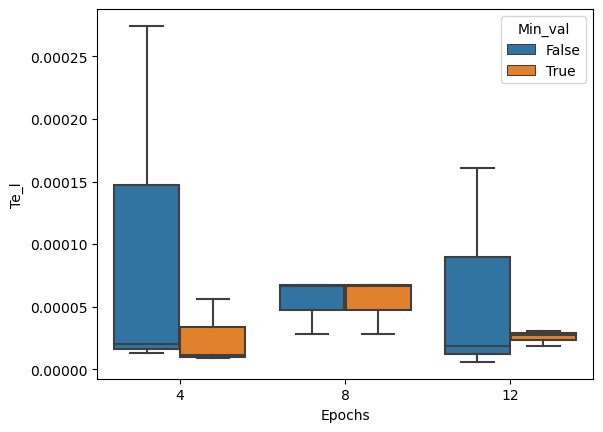

In [24]:
f = (results.Dor ==0) &(results.Model_type ==2)  #& (results.Min_val == True)  
sns.boxplot(x = "Epochs", y = "Te_l",data=results[f],hue = "Min_val")

<Axes: xlabel='Epochs', ylabel='Te_l'>

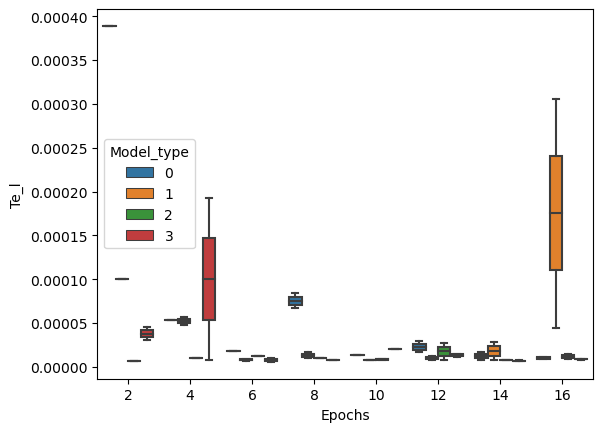

In [48]:
f = (results.Lr ==0.01)#(results.Dor ==0) #& (results.Min_val == True)  
sns.boxplot(x = "Epochs", y = "Te_l",data=results[f],hue = "Model_type")

## Old code 

In [ ]:
learning_rates = [0.01*4**i for i in range(3)]
loss_fn = torch.nn.MSELoss()
nbs_e = [2,4]#,4,8]
i=0
nbs_hidden = [0,1,2,3]
results = pd.DataFrame()
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            m = create_model(nb_hidden,input_size=d_ft_in['train'].shape[1])
            m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr"
            optimizer = torch.optim.Adam(m.parameters(), lr=lr)
            train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,True)
            
            saved_models = dict()
            
            for mt in ["min_val","all_epochs"]:
                path = f"trained_models/{mt}/model_{m_name}.pth"

                
                model = m
                m.load_state_dict(torch.load(path))
                m.eval()

                test_predictions = m(d_ft_in["test"].float())
                test_loss = loss_fn(test_predictions,d_ft_out["test"])
                
                train_predictions = m(d_ft_in["train"].float())
                train_loss = loss_fn(train_predictions,d_ft_out["train"])
                
                validation_prediction = m(d_ft_in["val"].float())
                validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                if mt == "min_val": 
                    min_val = True
                else: 
                    min_val = False

                r = pd.DataFrame({"Model_type": nb_hidden,"Min_val":min_val,"Epochs": nb_e,"Lr":lr, "Tr_l":train_loss.item(),"Te_l":test_loss.item(),"V_l": validation_loss.item()},index = [i]
                )
                i+=1
                results = pd.concat([results,r])